In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset with augmentation for training set
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:07<00:00, 1369784.90it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 99343.34it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 917687.16it/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4733050.63it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
# Define hyperparameters to tune
hidden_layer_sizes = [128, 256, 512]
learning_rates = [0.001, 0.01, 0.1]

# Define validation set split
validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Define samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32)


Epoch [1/10], Train Loss: 0.7726, Val Loss: 0.5210
Epoch [2/10], Train Loss: 0.4654, Val Loss: 0.4271
Epoch [3/10], Train Loss: 0.4139, Val Loss: 0.3889
Epoch [4/10], Train Loss: 0.3820, Val Loss: 0.4052
Epoch [5/10], Train Loss: 0.3649, Val Loss: 0.3509
Epoch [6/10], Train Loss: 0.3456, Val Loss: 0.3363
Epoch [7/10], Train Loss: 0.3408, Val Loss: 0.3513
Epoch [8/10], Train Loss: 0.3286, Val Loss: 0.3292
Epoch [9/10], Train Loss: 0.3158, Val Loss: 0.3292
Epoch [10/10], Train Loss: 0.3145, Val Loss: 0.3034
Validation Accuracy: 90.53%, Validation Loss: 0.3053
Test Accuracy: 57.91%, Test Loss: 1.1173


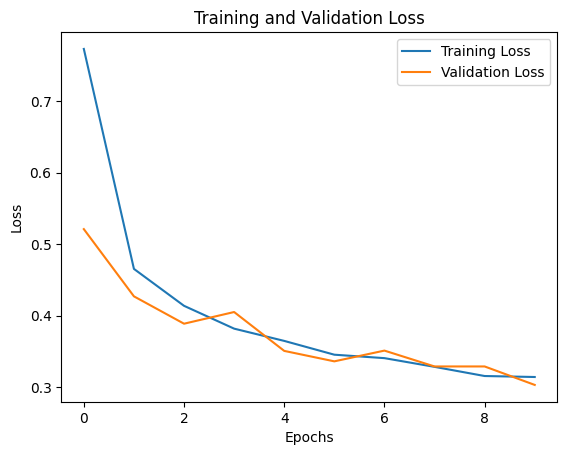

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Function for model training
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Initialize model, criterion, and optimizer
ffnn_model = NeuralNet(28*28, 256, 10)
criterion = nn.CrossEntropyLoss()
optimizer_ffnn = optim.Adam(ffnn_model.parameters(), lr=0.001)

# Train the model
train_losses_ffnn, val_losses_ffnn = train(ffnn_model, criterion, optimizer_ffnn, train_loader, val_loader)

# Evaluate the model on test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    # print(f'Test Accuracy: {accuracy:.2f}%, Test Loss: {avg_loss:.4f}')
    return accuracy, avg_loss

val_accuracy_ffnn, val_loss_ffnn = evaluate_model(ffnn_model, val_loader, criterion)
print(f'Validation Accuracy: {val_accuracy_ffnn:.2f}%, Validation Loss: {val_loss_ffnn:.4f}')
test_accuracy_ffnn, test_loss_ffnn = evaluate_model(ffnn_model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy_ffnn:.2f}%, Test Loss: {test_loss_ffnn:.4f}')
# Visualize training and validation loss
plt.plot(train_losses_ffnn, label='Training Loss')
plt.plot(val_losses_ffnn, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [6]:
# Number of parameters and FLOPs
!pip install torchprofile
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from flopth import flopth
# Profile the model
flops_ffnn, num_parameters_ffnn = flopth(ffnn_model, in_size=(28*28,),show_detail=True)
print(flops_ffnn,num_parameters_ffnn)

# Generate confusion matrix, precision, and recall
def generate_confusion_matrix(model, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.tolist())
            all_targets.extend(labels.tolist())
    conf_mat_result = confusion_matrix(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    return conf_mat_result, precision, recall

# Call the function to generate confusion matrix, precision, and recall
conf_mat_result, precision, recall = generate_confusion_matrix(ffnn_model, test_loader)
print(f'Confusion Matrix:\n{conf_mat_result}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


ModuleNotFoundError: No module named 'flopth'

#CNN

In [8]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 7 * 7, 10)  # MNIST images are 28x28 after pooling twice

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc(x)
        return x

# Initialize the model
cnn_model = CNN()


In [9]:
# Define hyperparameters grid
param_grid = {'conv1_filters': [16, 32, 64],
              'conv2_filters': [32, 64, 128],
              'learning_rate': [0.001, 0.01, 0.1]}

# Perform hyperparameter tuning using grid search or other techniques
# Track the model's performance on the validation set during training
# Select the hyperparameters that yield the best results
# Example:
best_params = {'conv1_filters': 32, 'conv2_filters': 64, 'learning_rate': 0.001}


Epoch [1/10], Train Loss: 0.6707, Val Loss: 0.4316
Epoch [2/10], Train Loss: 0.3457, Val Loss: 0.3013
Epoch [3/10], Train Loss: 0.2877, Val Loss: 0.2969
Epoch [4/10], Train Loss: 0.2558, Val Loss: 0.2496
Epoch [5/10], Train Loss: 0.2378, Val Loss: 0.2437
Epoch [6/10], Train Loss: 0.2192, Val Loss: 0.2271
Epoch [7/10], Train Loss: 0.2077, Val Loss: 0.2050
Epoch [8/10], Train Loss: 0.2000, Val Loss: 0.2070
Epoch [9/10], Train Loss: 0.1935, Val Loss: 0.1888
Epoch [10/10], Train Loss: 0.1857, Val Loss: 0.1859
Validation Accuracy: 93.98%, Validation Loss: 0.1944
Test Accuracy: 84.71%, Test Loss: 0.6615


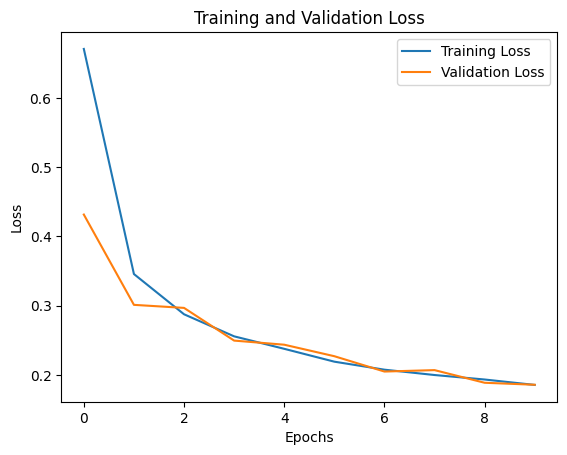

In [10]:
# Define optimizer and loss function
optimizer = optim.Adam(cnn_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.CrossEntropyLoss()

# Train the model
train_losses_cnn, val_losses_cnn = train(cnn_model, criterion, optimizer, train_loader, val_loader)

# Evaluate the model on validation and test sets
val_accuracy_cnn, val_loss_cnn = evaluate_model(cnn_model, val_loader, criterion)
print(f'Validation Accuracy: {val_accuracy_cnn:.2f}%, Validation Loss: {val_loss_cnn:.4f}')
test_accuracy_cnn, test_loss_cnn = evaluate_model(cnn_model, test_loader, criterion)
print(f'Test Accuracy: {test_accuracy_cnn:.2f}%, Test Loss: {test_loss_cnn:.4f}')

# Visualize training and validation loss
plt.plot(train_losses_cnn, label='Training Loss')
plt.plot(val_losses_cnn, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Compare the accuracy, precision, and recall scores of CNN and feedforward neural network models
print("\nComparison of Performance Metrics:")
print("CNN Model:")
print(f"Validation Accuracy: {val_accuracy_cnn:.2f}%, Validation Loss: {val_loss_cnn:.4f}")
print(f"Test Accuracy: {test_accuracy_cnn:.2f}%, Test Loss: {test_loss_cnn:.4f}")
print("\nFeedforward Neural Network Model:")
print(f"Validation Accuracy: {val_accuracy_ffnn:.2f}%, Validation Loss: {val_loss_ffnn:.4f}")
print(f"Test Accuracy: {test_accuracy_ffnn:.2f}%, Test Loss: {test_loss_ffnn:.4f}")

# Calculate FLOPs and Number of parameters for both models
# from flopth import flopth
# flops_cnn, num_parameters_cnn = flopth(cnn_model,show_detail=True)
# print("\nComparison of Number of Trainable Parameters:")
# print(f"CNN Model: {num_parameters_cnn} parameters")
# print(f"Feedforward Neural Network Model: {num_parameters_ffnn} parameters")
# print("\nComparison of FLOPS:")
# print(flops_ffnn)
# print(flops_cnn)
